# File for looking at simplistic target and pathway overlap using the Jaccard Similarity #

- Using the syntoxtarg_allpw.csv and syntoxtarg_lowestpw.csv

Steps to take:
1. For all available drug combinations, find the Jaccard similarity for targets
2. For all available drug combinations, find the Jaccard similarity for lowest pathway levels
3. For all available drug combinations, find the Jaccard similarity for all pathway levels

In [1]:
# Import everything needed
from scipy import stats
from toxicity_ranking import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp

In [2]:
ddinter_df = get_ddinter_data()
drugcomb_df = get_drug_comb_data(bliss=True, loewe=True, hsa=True, zip=True)
drug_syntox_df, major_pairs, moderate_pairs, minor_pairs, unknown_pairs = find_drugcomb_ddinter_intersect(drugcomb_df, ddinter_df)

# remove pairs that have unknown toxicity
drug_syntox_df = drug_syntox_df[~drug_syntox_df['toxicity_category'].str.contains('Unknown')]
drug_syntox_df

/Users/alexwong/Research/toxicity-cancer-drug-combination/toxicity_ranking.py:17: DtypeWarning: Columns (2,7,19,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  drugcomb_df = pd.read_csv('data/DrugComb/drugcomb_summary_v_1_5.csv', sep=',', index_col=False)


Original shape of drugcomb data:  (1432351, 26)
Final shape of filtered drugcomb data:  (123882, 26)
Number of drugs in common between drugcomb and ddinter [lowercase enforced]:  486
Major pairs in both DrugComb and in DDInter:  335
Moderate pairs in both DrugComb and in DDInter:  1027
Minor pairs in both DrugComb and in DDInter:  59
Unknown toxicity pairs in both DrugComb and in DDInter:  573
Total common pairs:  1994
Total known pairs:  1421


,drug_row,drug_col,cell_line_name,synergy_zip,synergy_loewe,synergy_bliss,synergy_hsa,toxicity_category
0,mefloquine,tamoxifen,TC-32,19.667559,2.263512,25.542924,2.896978,Moderate
0,prochlorperazine,tamoxifen,TC-32,12.411371,1.358891,14.291624,0.880952,Moderate
0,fostamatinib,tamoxifen,TC-32,3.338772,0.978715,5.558614,3.517400,Moderate
0,fingolimod,mefloquine,TC-32,13.752458,5.414303,19.114025,5.235783,Major
0,dasatinib,mefloquine,TC-32,3.325308,1.635582,8.657774,1.804910,Moderate
...,...,...,...,...,...,...,...,...
0,nilotinib,nilutamide,CBRC058,5.535107,15.599357,10.186144,4.857233,Major
0,crizotinib,nilutamide,CBRC058,39.136320,18.177696,48.520228,20.090507,Major
0,sorafenib,nilutamide,CBRC058,13.085942,15.100112,25.848957,11.014048,Moderate
0,vincristine,midostaurin,CBRC058,10.768074,5.982307,8.609542,3.406801,Moderate


In [4]:
syntoxtarg_allpw_df = pd.read_csv('data_processed/syntoxtarg_allpw.csv')
syntoxtarg_lowestpw_df = pd.read_csv('data_processed/syntoxtarg_lowestpw.csv')

syntoxtarg_allpw_df

,drug_name,target_name,target_DrugBank_ID,UniProtKB_ID,Reactome_ID,Pathway_Name
0,acetohexamide,ATP-sensitive inward rectifier potassium chann...,BE0000644,P48048,R-HSA-112316,Neuronal System
1,acetohexamide,ATP-sensitive inward rectifier potassium chann...,BE0000644,P48048,R-HSA-1296065,Inwardly rectifying K+ channels
2,acetohexamide,ATP-sensitive inward rectifier potassium chann...,BE0000644,P48048,R-HSA-1296067,Potassium transport channels
3,acetohexamide,ATP-sensitive inward rectifier potassium chann...,BE0000644,P48048,R-HSA-1296071,Potassium Channels
4,ceritinib,ALK tyrosine kinase receptor,BE0000359,Q9UM73,R-HSA-162582,Signal Transduction
...,...,...,...,...,...,...
24438,dopamine,Synaptic vesicular amine transporter,BE0000118,Q05940,R-HSA-212676,Dopamine Neurotransmitter Release Cycle
24439,dopamine,Synaptic vesicular amine transporter,BE0000118,Q05940,R-HSA-382551,Transport of small molecules
24440,dopamine,Synaptic vesicular amine transporter,BE0000118,Q05940,R-HSA-425366,"Transport of bile salts and organic acids, met..."
24441,dopamine,Synaptic vesicular amine transporter,BE0000118,Q05940,R-HSA-425407,SLC-mediated transmembrane transport


In [14]:
# Function to get the jaccard similarity between two sets of drug targets or pathways
def targ_pw_js(drug1, drug2, target_or_pathway_df, type='target'):
    if type not in ['target', 'pathway']:
        raise ValueError('type must be either target or pathway')
    if type == 'target':
        drug1_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug1]['target_DrugBank_ID'])
        drug2_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug2]['target_DrugBank_ID'])
    else:
        drug1_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug1]['Reactome_ID'])
        drug2_set = set(target_or_pathway_df[target_or_pathway_df['drug_name'] == drug2]['Reactome_ID'])
    
    if len(drug1_set) == 0 or len(drug2_set) == 0:
        return None

    return jaccard_similarity(drug1_set, drug2_set)

# Test this function
print(targ_pw_js('ceritinib', 'levonorgestrel', syntoxtarg_allpw_df, type='target')) # Should be zero
print(targ_pw_js('testosterone', 'levonorgestrel', syntoxtarg_allpw_df, type='target')) # Should be positive
print(targ_pw_js('methotrexate', 'chlorphenesin', syntoxtarg_allpw_df, type='target')) # Should be None
print(targ_pw_js('mycophenolic acid', 'rucaparib', syntoxtarg_lowestpw_df, type='pathway')) # Should be zero
print(targ_pw_js('testosterone', 'levonorgestrel', syntoxtarg_allpw_df, type='pathway')) # Should be positive
print(targ_pw_js('methotrexate', 'chlorphenesin', syntoxtarg_allpw_df, type='pathway')) # Should be None


0.0
0.3333333333333333
None
0.0
0.71875
None


In [18]:
# Create a new column in the drug_syntox_df that contains the jaccard similarity between the target sets of the drug pair
drug_syntox_df['target_jaccard'] = drug_syntox_df.apply(lambda row: targ_pw_js(row['drug_row'], row['drug_col'], syntoxtarg_allpw_df, 'target'), axis=1)
drug_syntox_df['all_pw_jaccard'] = drug_syntox_df.apply(lambda row: targ_pw_js(row['drug_row'], row['drug_col'], syntoxtarg_allpw_df, 'pathway'), axis=1)
drug_syntox_df['lowest_pw_jaccard'] = drug_syntox_df.apply(lambda row: targ_pw_js(row['drug_row'], row['drug_col'], syntoxtarg_lowestpw_df, 'pathway'), axis=1)

In [19]:
# How many pairs have a target jaccard similarity of None
print(len(drug_syntox_df[drug_syntox_df['target_jaccard'].isnull()]))

# How many pairs have a target jaccard similarity of zero?
print(len(drug_syntox_df[drug_syntox_df['target_jaccard'] == 0]))

# How many pairs have a pathway jaccard similarity of None?
print(len(drug_syntox_df[drug_syntox_df['all_pw_jaccard'].isnull()]))

# How many pairs have a pathway jaccard similarity of zero?
print(len(drug_syntox_df[drug_syntox_df['all_pw_jaccard'] == 0]))

# How many pairs have a pathway jaccard similarity of None?
print(len(drug_syntox_df[drug_syntox_df['lowest_pw_jaccard'].isnull()]))

# How many pairs have a pathway jaccard similarity of zero?
print(len(drug_syntox_df[drug_syntox_df['lowest_pw_jaccard'] == 0]))

drug_syntox_df

834
5455
834
619
834
3524


,drug_row,drug_col,cell_line_name,synergy_zip,synergy_loewe,synergy_bliss,synergy_hsa,toxicity_category,target_jaccard,all_pw_jaccard,lowest_pw_jaccard
0,mefloquine,tamoxifen,TC-32,19.667559,2.263512,25.542924,2.896978,Moderate,0.0,0.027473,0.000000
0,prochlorperazine,tamoxifen,TC-32,12.411371,1.358891,14.291624,0.880952,Moderate,0.0,0.065574,0.015625
0,fostamatinib,tamoxifen,TC-32,3.338772,0.978715,5.558614,3.517400,Moderate,0.0,0.135734,0.049931
0,fingolimod,mefloquine,TC-32,13.752458,5.414303,19.114025,5.235783,Major,0.0,0.058824,0.000000
0,dasatinib,mefloquine,TC-32,3.325308,1.635582,8.657774,1.804910,Moderate,0.0,0.022472,0.005236
...,...,...,...,...,...,...,...,...,...,...,...
0,nilotinib,nilutamide,CBRC058,5.535107,15.599357,10.186144,4.857233,Major,0.0,0.114583,0.026316
0,crizotinib,nilutamide,CBRC058,39.136320,18.177696,48.520228,20.090507,Major,0.0,0.051948,0.000000
0,sorafenib,nilutamide,CBRC058,13.085942,15.100112,25.848957,11.014048,Moderate,0.0,0.029586,0.000000
0,vincristine,midostaurin,CBRC058,10.768074,5.982307,8.609542,3.406801,Moderate,0.0,0.086207,0.000000


(array([5.462e+03, 1.840e+02, 3.000e+01, 2.900e+01, 1.400e+01, 2.000e+00,
        9.200e+01, 0.000e+00, 0.000e+00, 5.200e+01, 8.700e+01, 0.000e+00,
        0.000e+00, 2.600e+01, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 6.000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

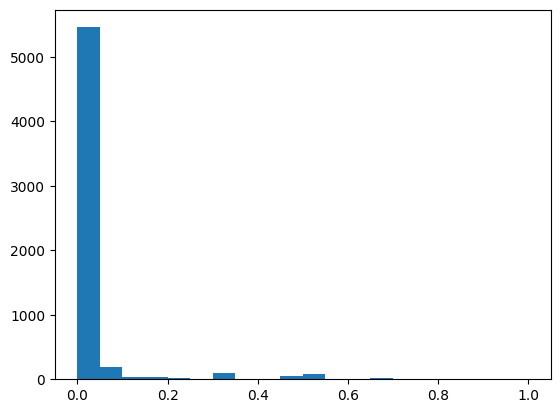

In [ ]:
# Look at histogram of target jaccard similarities
plt.hist(drug_syntox_df['target_jaccard'], bins=20)

(array([2.423e+03, 1.810e+03, 9.830e+02, 2.850e+02, 5.400e+01, 7.100e+01,
        2.200e+01, 7.000e+00, 2.200e+01, 5.100e+01, 6.000e+00, 2.000e+00,
        6.000e+00, 4.900e+01, 0.000e+00, 8.700e+01, 6.900e+01, 1.200e+01,
        0.000e+00, 2.700e+01]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

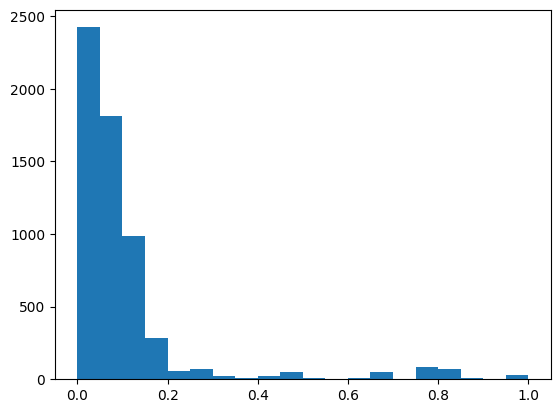

In [25]:
# Look at histogram of pathway jaccard similarities
plt.hist(drug_syntox_df['all_pw_jaccard'], bins=20)

(array([5.061e+03, 2.850e+02, 7.800e+01, 1.670e+02, 5.400e+01, 1.400e+01,
        1.200e+01, 2.000e+00, 0.000e+00, 5.300e+01, 1.200e+01, 0.000e+00,
        1.300e+01, 4.000e+01, 6.900e+01, 8.700e+01, 1.200e+01, 0.000e+00,
        0.000e+00, 2.700e+01]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

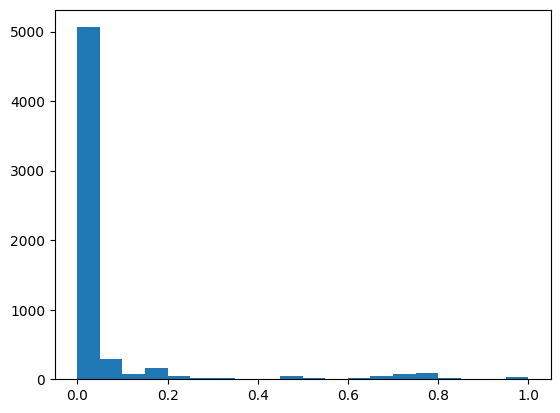

In [26]:
# Look at histogram of lowest pathway jaccard similarities
plt.hist(drug_syntox_df['lowest_pw_jaccard'], bins=20)

Then break down the dataset in different ways and see if there are any correlations. None of these Jaccard similarities are a normal distribution, so probably look at using a Kruskal Wallis test:
1. Break down by Major, Moderate, Minor toxicity, is there any difference in Jaccard similarity by these groups?

In [27]:
# Run Kruskal Wallis test on jaccard similarities with targeting Major, Moderate, and Minor toxicity

# Target jaccard
major_target = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Major']['target_jaccard'].dropna()
moderate_target = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Moderate']['target_jaccard'].dropna()
minor_target = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Minor']['target_jaccard'].dropna()
print(f'Major target jaccard: {len(major_target)}')
print(f'Moderate target jaccard: {len(moderate_target)}')
print(f'Minor target jaccard: {len(minor_target)}')

h_statistic_target_tox, p_value_target_tox = stats.kruskal(major_target, moderate_target, minor_target)
print(f'Kruskal-Wallis H statistic for target jaccard: {h_statistic_target_tox}')
print(f'P-value for target jaccard: {p_value_target_tox}')

# Filter drug_syntox_df for only Major, Moderate, and Minor toxicity categories and remove pairs with target jaccard similarity of None
drug_syntox_df_tox_target = drug_syntox_df[drug_syntox_df['toxicity_category'].isin(['Major', 'Moderate', 'Minor'])]
drug_syntox_df_tox_target = drug_syntox_df_tox_target[~drug_syntox_df_tox_target['target_jaccard'].isnull()]
dunn_target_tox = sp.posthoc_dunn(drug_syntox_df_tox_target, val_col='target_jaccard', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for target jaccard:' + str(dunn_target_tox))

with open('results/target_tox_kruskal_dunn.txt', 'w') as f:
    f.write(f'Kruskal-Wallis H statistic for target jaccard: {h_statistic_target_tox}\n')
    f.write(f'P-value for target jaccard: {p_value_target_tox}\n')
    f.write('Dunn post-hoc test for target jaccard:\n')
    f.write(str(dunn_target_tox))


Major target jaccard: 1037
Moderate target jaccard: 4821
Minor target jaccard: 128
Kruskal-Wallis H statistic for target jaccard: 14.207614300880795
P-value for target jaccard: 0.0008219695968107196
Dunn post-hoc test for target jaccard:             Major     Minor  Moderate
Major     1.000000  0.294575  0.018820
Minor     0.294575  1.000000  0.016578
Moderate  0.018820  0.016578  1.000000


In [28]:
# Pathway (all levels) jaccard
major_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Major']['all_pw_jaccard'].dropna()
moderate_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Moderate']['all_pw_jaccard'].dropna()
minor_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Minor']['all_pw_jaccard'].dropna()
print(f'Major all pathway jaccard: {len(major_allpw)}')
print(f'Moderate all pathway jaccard: {len(moderate_allpw)}')
print(f'Minor all pathway jaccard: {len(minor_allpw)}')

h_statistic_allpw_tox, p_value_allpw_tox = stats.kruskal(major_allpw, moderate_allpw, minor_allpw)
print(f'Kruskal-Wallis H statistic for all pathway jaccard: {h_statistic_allpw_tox}')
print(f'P-value for all pathway jaccard: {p_value_allpw_tox}')

# Filter drug_syntox_df for only Major, Moderate, and Minor toxicity categories and remove pairs with all pathway levels jaccard similarity of None
drug_syntox_df_tox_allpw = drug_syntox_df[drug_syntox_df['toxicity_category'].isin(['Major', 'Moderate', 'Minor'])]
drug_syntox_df_tox_allpw = drug_syntox_df_tox_allpw[~drug_syntox_df_tox_allpw['all_pw_jaccard'].isnull()]
dunn_allpw_tox = sp.posthoc_dunn(drug_syntox_df_tox_allpw, val_col='all_pw_jaccard', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for all pathway jaccard:' + str(dunn_allpw_tox))

with open('results/allpw_tox_kruskal_dunn.txt', 'w') as f:
    f.write(f'Kruskal-Wallis H statistic for all pathway jaccard: {h_statistic_allpw_tox}\n')
    f.write(f'P-value for all pathway jaccard: {p_value_allpw_tox}\n')
    f.write('Dunn post-hoc test for all pathway jaccard:\n')
    f.write(str(dunn_allpw_tox))

Major all pathway jaccard: 1037
Moderate all pathway jaccard: 4821
Minor all pathway jaccard: 128
Kruskal-Wallis H statistic for all pathway jaccard: 52.42427443159122
P-value for all pathway jaccard: 4.132505576481484e-12
Dunn post-hoc test for all pathway jaccard:                 Major     Minor      Moderate
Major     1.000000e+00  0.203316  1.435555e-12
Minor     2.033160e-01  1.000000  1.000000e+00
Moderate  1.435555e-12  1.000000  1.000000e+00


In [29]:
# Pathway (lowest levels) jaccard
major_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Major']['lowest_pw_jaccard'].dropna()
moderate_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Moderate']['lowest_pw_jaccard'].dropna()
minor_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'] == 'Minor']['lowest_pw_jaccard'].dropna()
print(f'Major lowest pathway jaccard: {len(major_lowestpw)}')
print(f'Moderate lowest pathway jaccard: {len(moderate_lowestpw)}')
print(f'Minor lowest pathway jaccard: {len(minor_lowestpw)}')

h_statistic_lowestpw_tox, p_value_lowestpw_tox = stats.kruskal(major_lowestpw, moderate_lowestpw, minor_lowestpw)
print(f'Kruskal-Wallis H statistic for lowest pathway jaccard: {h_statistic_lowestpw_tox}')
print(f'P-value for lowest pathway jaccard: {p_value_lowestpw_tox}')

# Filter drug_syntox_df for only Major, Moderate, and Minor toxicity categories and remove pairs with lowest pathway levels jaccard similarity of None
drug_syntox_df_tox_lowestpw = drug_syntox_df[drug_syntox_df['toxicity_category'].isin(['Major', 'Moderate', 'Minor'])]
drug_syntox_df_tox_lowestpw = drug_syntox_df_tox_lowestpw[~drug_syntox_df_tox_lowestpw['lowest_pw_jaccard'].isnull()]
dunn_lowestpw_tox = sp.posthoc_dunn(drug_syntox_df_tox_lowestpw, val_col='lowest_pw_jaccard', group_col='toxicity_category', p_adjust='bonferroni')
print('Dunn post-hoc test for lowest pathway jaccard:' + str(dunn_lowestpw_tox))

with open('results/lowestpw_tox_kruskal_dunn.txt', 'w') as f:
    f.write(f'Kruskal-Wallis H statistic for lowest pathway jaccard: {h_statistic_lowestpw_tox}\n')
    f.write(f'P-value for lowest pathway jaccard: {p_value_lowestpw_tox}\n')
    f.write('Dunn post-hoc test for lowest pathway jaccard:\n')
    f.write(str(dunn_lowestpw_tox))

Major lowest pathway jaccard: 1037
Moderate lowest pathway jaccard: 4821
Minor lowest pathway jaccard: 128
Kruskal-Wallis H statistic for lowest pathway jaccard: 118.95801507732517
P-value for lowest pathway jaccard: 1.4743318132441406e-26
Dunn post-hoc test for lowest pathway jaccard:                 Major     Minor      Moderate
Major     1.000000e+00  0.520422  2.208451e-26
Minor     5.204220e-01  1.000000  2.225375e-02
Moderate  2.208451e-26  0.022254  1.000000e+00


2. Could try to do a continuous correlation between synergy scores and Jaccard similarity distributions between these groups
    1. Do for Bliss, HSA, ZIP, Loewe synergy scores

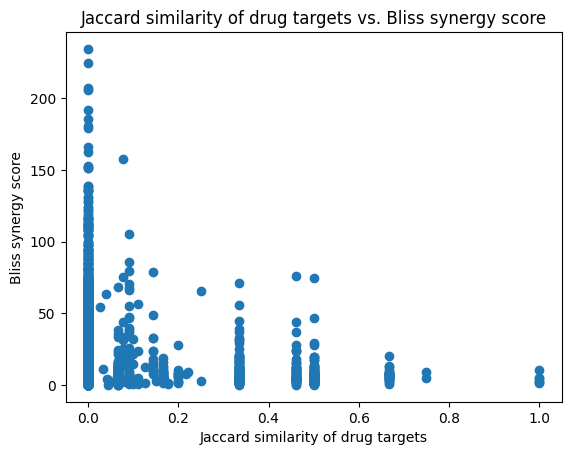

Pearson correlation coefficient between target jaccard similarity and bliss synergy score: -0.039818147779441634
Spearman correlation coefficient between target jaccard similarity and bliss synergy score: -0.010524911829095498


In [34]:
# Let's plot jaccard similarities against bliss synergy scores
plt.scatter(drug_syntox_df['target_jaccard'], drug_syntox_df['synergy_bliss'])
plt.xlabel('Jaccard similarity of drug targets')
plt.ylabel('Bliss synergy score')
plt.title('Jaccard similarity of drug targets vs. Bliss synergy score')
plt.show()

# Calculate Pearson correlation coefficient between target jaccard similarity and bliss synergy score
target_jaccard_bliss_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_bliss'])
print(f'Pearson correlation coefficient between target jaccard similarity and bliss synergy score: {target_jaccard_bliss_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and bliss synergy score
target_jaccard_bliss_spearman_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_bliss'], method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and bliss synergy score: {target_jaccard_bliss_spearman_corr}')


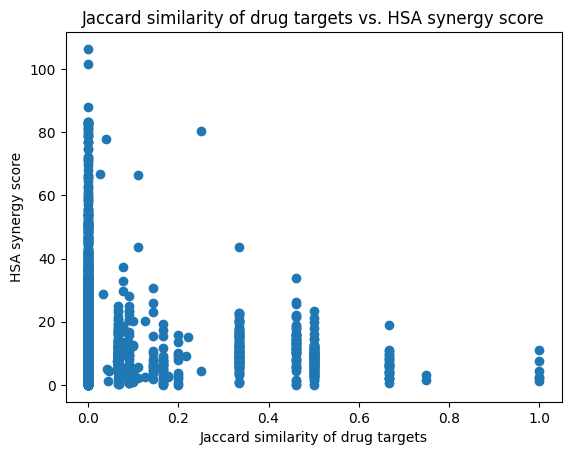

Pearson correlation coefficient between target jaccard similarity and HSA synergy score: -0.02256284411615121
Spearman correlation coefficient between target jaccard similarity and HSA synergy score: 0.017535999813823238


In [35]:
# Let's plot jaccard similarities against HSA synergy scores
plt.scatter(drug_syntox_df['target_jaccard'], drug_syntox_df['synergy_hsa'])
plt.xlabel('Jaccard similarity of drug targets')
plt.ylabel('HSA synergy score')
plt.title('Jaccard similarity of drug targets vs. HSA synergy score')
plt.show()

# Calculate Pearson correlation coefficient between target jaccard similarity and HSA synergy score
target_jaccard_hsa_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_hsa'])
print(f'Pearson correlation coefficient between target jaccard similarity and HSA synergy score: {target_jaccard_hsa_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and HSA synergy score
target_jaccard_hsa_spearman_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_hsa'], method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and HSA synergy score: {target_jaccard_hsa_spearman_corr}')

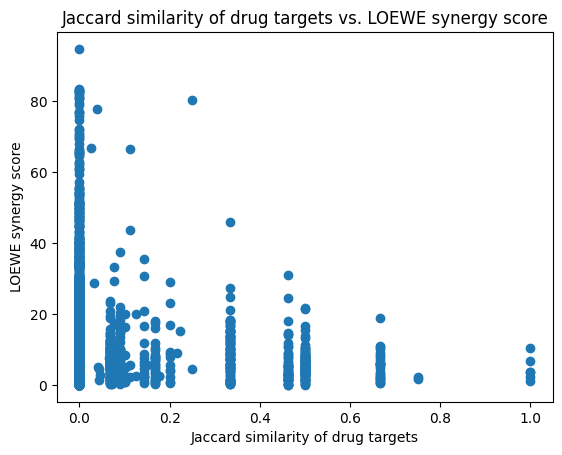

Pearson correlation coefficient between target jaccard similarity and LOEWE synergy score: -0.030194253967328763
Spearman correlation coefficient between target jaccard similarity and LOEWE synergy score: 0.016160382098137915


In [36]:
# Let's plot jaccard similarities against LOEWE synergy scores
plt.scatter(drug_syntox_df['target_jaccard'], drug_syntox_df['synergy_loewe'])
plt.xlabel('Jaccard similarity of drug targets')
plt.ylabel('LOEWE synergy score')
plt.title('Jaccard similarity of drug targets vs. LOEWE synergy score')
plt.show()

# Calculate Pearson correlation coefficient between target jaccard similarity and LOEWE synergy score
target_jaccard_loewe_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_loewe'])
print(f'Pearson correlation coefficient between target jaccard similarity and LOEWE synergy score: {target_jaccard_loewe_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and LOEWE synergy score
target_jaccard_loewe_spearman_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_loewe'], method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and LOEWE synergy score: {target_jaccard_loewe_spearman_corr}')


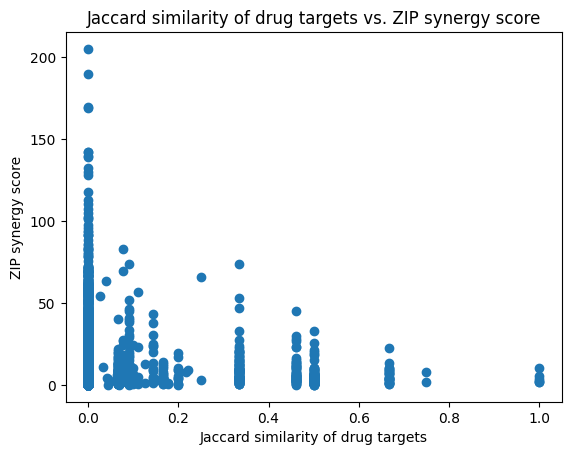

Pearson correlation coefficient between target jaccard similarity and ZIP synergy score: -0.0396297252937972
Spearman correlation coefficient between target jaccard similarity and ZIP synergy score: -0.01402576726889553


In [37]:
# Let's plot jaccard similarities against ZIP synergy scores
plt.scatter(drug_syntox_df['target_jaccard'], drug_syntox_df['synergy_zip'])
plt.xlabel('Jaccard similarity of drug targets')
plt.ylabel('ZIP synergy score')
plt.title('Jaccard similarity of drug targets vs. ZIP synergy score')
plt.show()

# Calculate Pearson correlation coefficient between target jaccard similarity and ZIP synergy score
target_jaccard_zip_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_zip'])
print(f'Pearson correlation coefficient between target jaccard similarity and ZIP synergy score: {target_jaccard_zip_corr}')

# Calculate Spearman correlation coefficient between target jaccard similarity and ZIP synergy score
target_jaccard_zip_spearman_corr = drug_syntox_df['target_jaccard'].corr(drug_syntox_df['synergy_zip'], method='spearman')
print(f'Spearman correlation coefficient between target jaccard similarity and ZIP synergy score: {target_jaccard_zip_spearman_corr}')

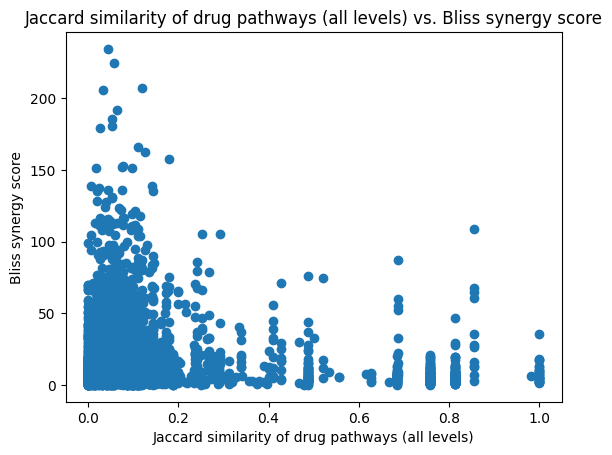

Pearson correlation coefficient between all pathway levels jaccard similarity and bliss synergy score: -0.013886550863608736
Spearman correlation coefficient between all pathway levels jaccard similarity and bliss synergy score: 0.10368981786601164


In [38]:
# Let's plot all pathway levels jaccard similarities against bliss synergy scores
plt.scatter(drug_syntox_df['all_pw_jaccard'], drug_syntox_df['synergy_bliss'])
plt.xlabel('Jaccard similarity of drug pathways (all levels)')
plt.ylabel('Bliss synergy score')
plt.title('Jaccard similarity of drug pathways (all levels) vs. Bliss synergy score')
plt.show()

# Calculate Pearson correlation coefficient between all pathway levels jaccard similarity and bliss synergy score
allpw_jaccard_bliss_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_bliss'])
print(f'Pearson correlation coefficient between all pathway levels jaccard similarity and bliss synergy score: {allpw_jaccard_bliss_corr}')

# Calculate Spearman correlation coefficient between all pathway levels jaccard similarity and bliss synergy score
allpw_jaccard_bliss_spearman_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_bliss'], method='spearman')
print(f'Spearman correlation coefficient between all pathway levels jaccard similarity and bliss synergy score: {allpw_jaccard_bliss_spearman_corr}')

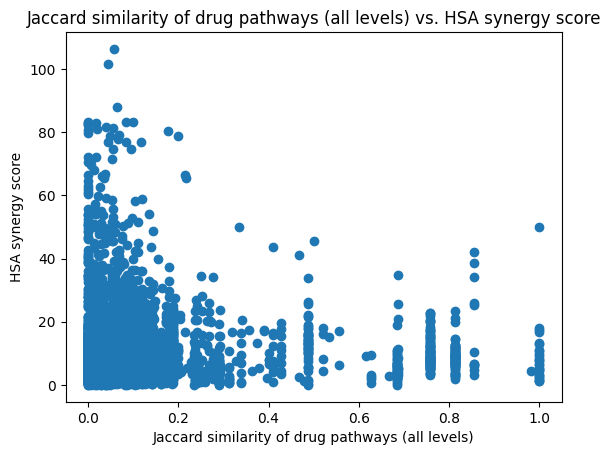

Pearson correlation coefficient between all pathway levels jaccard similarity and HSA synergy score: -0.020814295046639803
Spearman correlation coefficient between all pathway levels jaccard similarity and HSA synergy score: 0.020624303382729522


In [39]:
# Let's plot all pathway levels jaccard similarities against HSA synergy scores
plt.scatter(drug_syntox_df['all_pw_jaccard'], drug_syntox_df['synergy_hsa'])
plt.xlabel('Jaccard similarity of drug pathways (all levels)')
plt.ylabel('HSA synergy score')
plt.title('Jaccard similarity of drug pathways (all levels) vs. HSA synergy score')
plt.show()

# Calculate Pearson correlation coefficient between all pathway levels jaccard similarity and HSA synergy score
allpw_jaccard_hsa_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_hsa'])
print(f'Pearson correlation coefficient between all pathway levels jaccard similarity and HSA synergy score: {allpw_jaccard_hsa_corr}')

# Calculate Spearman correlation coefficient between all pathway levels jaccard similarity and HSA synergy score
allpw_jaccard_hsa_spearman_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_hsa'], method='spearman')
print(f'Spearman correlation coefficient between all pathway levels jaccard similarity and HSA synergy score: {allpw_jaccard_hsa_spearman_corr}')


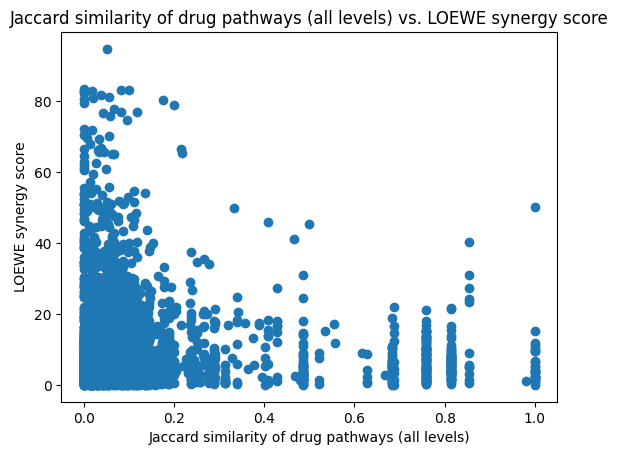

Pearson correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score: -0.02760740376494134
Spearman correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score: 0.04192542231398594


In [40]:
# Let's plot all pathway levels jaccard similarities against LOEWE synergy scores
plt.scatter(drug_syntox_df['all_pw_jaccard'], drug_syntox_df['synergy_loewe'])
plt.xlabel('Jaccard similarity of drug pathways (all levels)')
plt.ylabel('LOEWE synergy score')
plt.title('Jaccard similarity of drug pathways (all levels) vs. LOEWE synergy score')
plt.show()

# Calculate Pearson correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score
allpw_jaccard_loewe_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_loewe'])
print(f'Pearson correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score: {allpw_jaccard_loewe_corr}')

# Calculate Spearman correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score
allpw_jaccard_loewe_spearman_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_loewe'], method='spearman')
print(f'Spearman correlation coefficient between all pathway levels jaccard similarity and LOEWE synergy score: {allpw_jaccard_loewe_spearman_corr}')

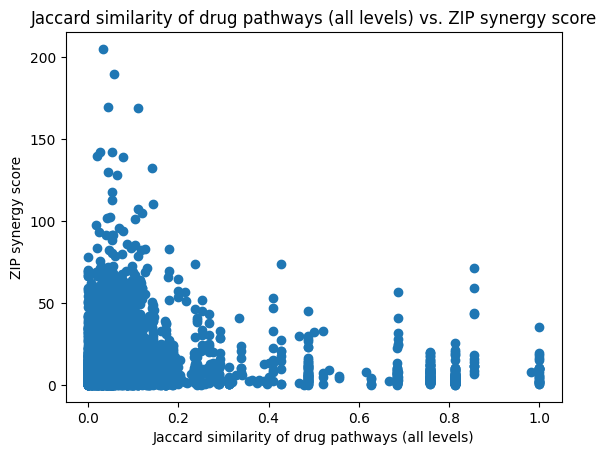

Pearson correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score: -0.017959831005642572
Spearman correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score: 0.06809533120995614


In [41]:
# Let's plot all pathway levels jaccard similarities against ZIP synergy scores
plt.scatter(drug_syntox_df['all_pw_jaccard'], drug_syntox_df['synergy_zip'])
plt.xlabel('Jaccard similarity of drug pathways (all levels)')
plt.ylabel('ZIP synergy score')
plt.title('Jaccard similarity of drug pathways (all levels) vs. ZIP synergy score')
plt.show()

# Calculate Pearson correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score
allpw_jaccard_zip_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_zip'])
print(f'Pearson correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score: {allpw_jaccard_zip_corr}')

# Calculate Spearman correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score
allpw_jaccard_zip_spearman_corr = drug_syntox_df['all_pw_jaccard'].corr(drug_syntox_df['synergy_zip'], method='spearman')
print(f'Spearman correlation coefficient between all pathway levels jaccard similarity and ZIP synergy score: {allpw_jaccard_zip_spearman_corr}')


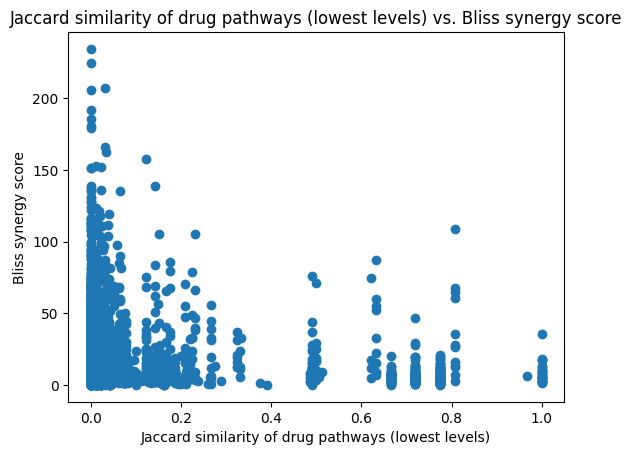

Pearson correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score: -0.025871595140891695
Spearman correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score: 0.06785260281711532


In [43]:
# Let's plot lowest pathway levels jaccard similarities against bliss synergy scores
plt.scatter(drug_syntox_df['lowest_pw_jaccard'], drug_syntox_df['synergy_bliss'])
plt.xlabel('Jaccard similarity of drug pathways (lowest levels)')
plt.ylabel('Bliss synergy score')
plt.title('Jaccard similarity of drug pathways (lowest levels) vs. Bliss synergy score')
plt.show()

# Calculate Pearson correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score
lowestpw_jaccard_bliss_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_bliss'])
print(f'Pearson correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score: {lowestpw_jaccard_bliss_corr}')

# Calculate Spearman correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score
lowestpw_jaccard_bliss_spearman_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_bliss'], method='spearman')
print(f'Spearman correlation coefficient between lowest pathway levels jaccard similarity and bliss synergy score: {lowestpw_jaccard_bliss_spearman_corr}')

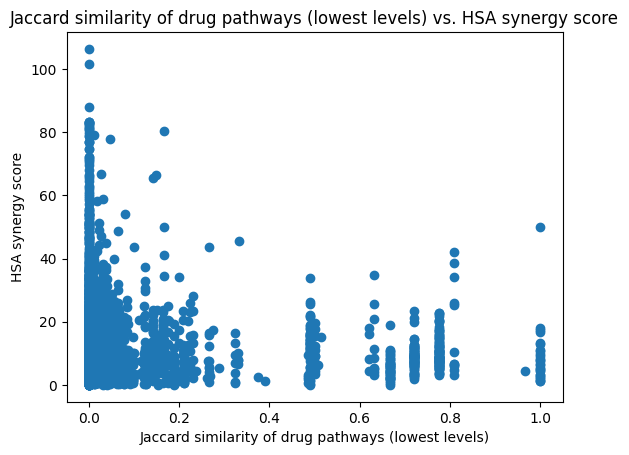

Pearson correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score: -0.014422243150394589
Spearman correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score: 0.01488328756477675


In [44]:
# Let's plot lowest pathway levels jaccard similarities against HSA synergy scores
plt.scatter(drug_syntox_df['lowest_pw_jaccard'], drug_syntox_df['synergy_hsa'])
plt.xlabel('Jaccard similarity of drug pathways (lowest levels)')
plt.ylabel('HSA synergy score')
plt.title('Jaccard similarity of drug pathways (lowest levels) vs. HSA synergy score')
plt.show()

# Calculate Pearson correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score
lowestpw_jaccard_hsa_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_hsa'])
print(f'Pearson correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score: {lowestpw_jaccard_hsa_corr}')

# Calculate Spearman correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score
lowestpw_jaccard_hsa_spearman_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_hsa'], method='spearman')
print(f'Spearman correlation coefficient between lowest pathway levels jaccard similarity and HSA synergy score: {lowestpw_jaccard_hsa_spearman_corr}')

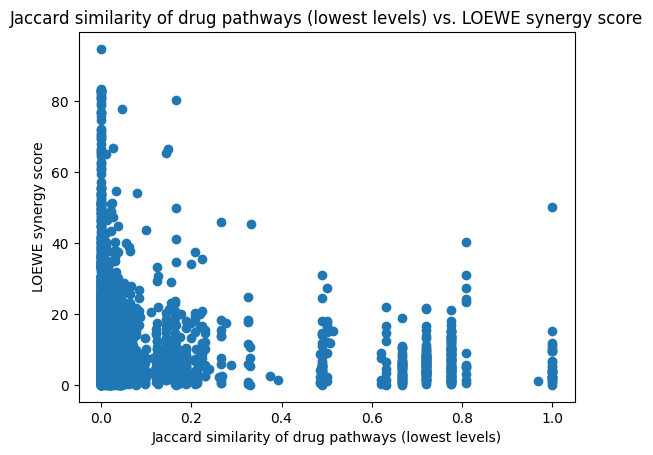

Pearson correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score: -0.024199121859189564
Spearman correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score: 0.04542118885821787


In [45]:
# Let's plot lowest pathway levels jaccard similarities against LOEWE synergy scores
plt.scatter(drug_syntox_df['lowest_pw_jaccard'], drug_syntox_df['synergy_loewe'])
plt.xlabel('Jaccard similarity of drug pathways (lowest levels)')
plt.ylabel('LOEWE synergy score')
plt.title('Jaccard similarity of drug pathways (lowest levels) vs. LOEWE synergy score')
plt.show()

# Calculate Pearson correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score
lowestpw_jaccard_loewe_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_loewe'])
print(f'Pearson correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score: {lowestpw_jaccard_loewe_corr}')

# Calculate Spearman correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score
lowestpw_jaccard_loewe_spearman_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_loewe'], method='spearman')
print(f'Spearman correlation coefficient between lowest pathway levels jaccard similarity and LOEWE synergy score: {lowestpw_jaccard_loewe_spearman_corr}')

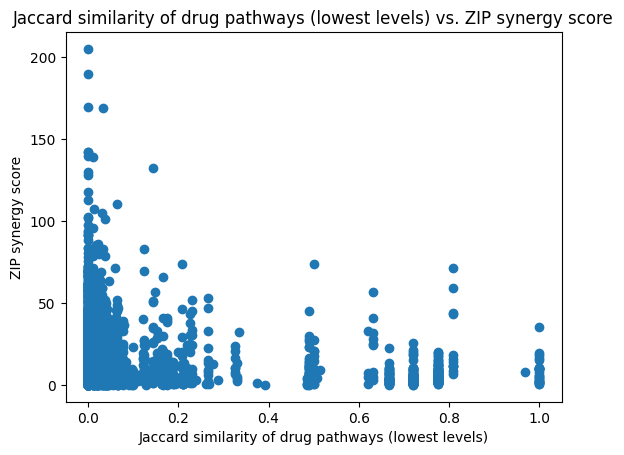

Pearson correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score: -0.027128329493099807
Spearman correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score: 0.032007783338185186


In [46]:
# Let's plot lowest pathway levels jaccard similarities against ZIP synergy scores
plt.scatter(drug_syntox_df['lowest_pw_jaccard'], drug_syntox_df['synergy_zip'])
plt.xlabel('Jaccard similarity of drug pathways (lowest levels)')
plt.ylabel('ZIP synergy score')
plt.title('Jaccard similarity of drug pathways (lowest levels) vs. ZIP synergy score')
plt.show()

# Calculate Pearson correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score
lowestpw_jaccard_zip_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_zip'])
print(f'Pearson correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score: {lowestpw_jaccard_zip_corr}')

# Calculate Spearman correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score
lowestpw_jaccard_zip_spearman_corr = drug_syntox_df['lowest_pw_jaccard'].corr(drug_syntox_df['synergy_zip'], method='spearman')
print(f'Spearman correlation coefficient between lowest pathway levels jaccard similarity and ZIP synergy score: {lowestpw_jaccard_zip_spearman_corr}')

3. Then look at smaller segment - for top 10% of synergy scores that also have Major Toxicity compared to the top 10% of synergy scores that have Moderate Toxicity compared to the top 10% synergy scores that have Minor Toxicity, is there a difference between Jaccard similarity scores